In [5]:
import os, glob, textwrap
DATA_DIR = os.path.join("..", "data")   # adjust if your notebook is in repo root; or use "data" if notebook at project root
print("Checking folder:", os.path.abspath(DATA_DIR))
files = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))
print(f"Found {len(files)} CSV files:")
for f in files:
    print(" -", os.path.basename(f))


Checking folder: c:\Users\sriji\Documents\Uber_Pickup_Analyzation\data
Found 20 CSV files:
 - Uber-Jan-Feb-FOIL.csv
 - other-American_B01362.csv
 - other-Carmel_B00256.csv
 - other-Dial7_B00887.csv
 - other-Diplo_B01196.csv
 - other-FHV-services_jan-aug-2015.csv
 - other-Federal_02216.csv
 - other-Firstclass_B01536.csv
 - other-Highclass_B01717.csv
 - other-Lyft_B02510.csv
 - other-Prestige_B01338.csv
 - other-Skyline_B00111.csv
 - sample-uber.csv
 - uber-raw-data-apr14.csv
 - uber-raw-data-aug14.csv
 - uber-raw-data-janjune-15.csv
 - uber-raw-data-jul14.csv
 - uber-raw-data-jun14.csv
 - uber-raw-data-may14.csv
 - uber-raw-data-sep14.csv


In [6]:
import pandas as pd
if not files:
    raise FileNotFoundError(f"No CSVs found in {DATA_DIR}. Make sure your data folder is at this path.")

sample_path = files[0]
print("Inspecting:", sample_path)
df_example = pd.read_csv(sample_path, nrows=5)
print("Columns:")
print(df_example.columns.tolist())
display(df_example.head())


Inspecting: ..\data\Uber-Jan-Feb-FOIL.csv
Columns:
['dispatching_base_number', 'date', 'active_vehicles', 'trips']


,dispatching_base_number,date,active_vehicles,trips
0,B02512,1/1/2015,190,1132
1,B02765,1/1/2015,225,1765
2,B02764,1/1/2015,3427,29421
3,B02682,1/1/2015,945,7679
4,B02617,1/1/2015,1228,9537


In [7]:
import os, glob, pandas as pd, numpy as np

DATA_DIR = os.path.join("..", "data")
OUT_FILE = os.path.join(DATA_DIR, "uber_cleaned.csv")

# helper lists (extend if your file uses other names)
DATETIME_KEYS = ["date/time", "date_time", "datetime", "date", "pickup_datetime", "timestamp", "pickup time", "pickup_time"]
LAT_KEYS = ["lat", "latitude", "pickup_latitude"]
LON_KEYS = ["lon", "lng", "longitude", "pickup_longitude", "long"]

def find_column(columns, candidates):
    cols_l = [c.lower().strip() for c in columns]
    for key in candidates:
        if key in cols_l:
            return columns[cols_l.index(key)]
    # try substring match
    for key in candidates:
        for i, c in enumerate(cols_l):
            if key in c:
                return columns[i]
    return None

csv_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {DATA_DIR}")

dfs = []
for f in csv_files:
    try:
        df = pd.read_csv(f, low_memory=False)
        df["__source_file"] = os.path.basename(f)
        dfs.append(df)
        print(f"Loaded {os.path.basename(f)}: {df.shape}")
    except Exception as e:
        print(f"Failed to load {f}: {e}")

df_all = pd.concat(dfs, ignore_index=True, sort=False)
print("Combined shape:", df_all.shape)

# detect datetime column
dt_col = find_column(df_all.columns, DATETIME_KEYS)
if dt_col is None:
    # try a more general heuristic
    for c in df_all.columns:
        if "time" in c.lower() or "date" in c.lower():
            dt_col = c
            break

if dt_col is None:
    raise RuntimeError("Could not find a datetime column automatically. Check column names and update DATETIME_KEYS.")

print("Using datetime column:", dt_col)
# parse datetime robustly
df_all[dt_col] = pd.to_datetime(df_all[dt_col], errors="coerce", infer_datetime_format=True)
df_all = df_all.rename(columns={dt_col: "pickup_datetime"})

# find lat/lon
lat_col = find_column(df_all.columns, LAT_KEYS)
lon_col = find_column(df_all.columns, LON_KEYS)
if lat_col and lon_col:
    df_all = df_all.rename(columns={lat_col: "lat", lon_col: "lon"})
    # drop null coords
    df_all = df_all[(df_all["lat"].notna()) & (df_all["lon"].notna())]
    # filter plausible ranges
    df_all = df_all[df_all["lat"].between(-90,90) & df_all["lon"].between(-180,180)]
else:
    print("Warning: lat/lon not auto-detected. Spatial plots will be skipped. You can set LAT_KEYS/LON_KEYS lists.")

# drop rows with invalid datetimes
before = len(df_all)
df_all = df_all[df_all["pickup_datetime"].notna()]
dropped = before - len(df_all)
print(f"Dropped {dropped} rows with invalid datetimes. Remaining rows: {len(df_all)}")

# extract time features
df_all["hour"] = df_all["pickup_datetime"].dt.hour.astype("Int64")
df_all["date"] = df_all["pickup_datetime"].dt.date
df_all["day"] = df_all["pickup_datetime"].dt.day.astype("Int64")
df_all["weekday"] = df_all["pickup_datetime"].dt.day_name()
df_all["month"] = df_all["pickup_datetime"].dt.month.astype("Int64")
df_all["year"] = df_all["pickup_datetime"].dt.year.astype("Int64")

# dedupe small duplicates
if {"lat","lon"}.issubset(df_all.columns):
    df_all = df_all.drop_duplicates(subset=["pickup_datetime","lat","lon"])
else:
    df_all = df_all.drop_duplicates(subset=["pickup_datetime","__source_file"])

# write to disk
df_all.to_csv(OUT_FILE, index=False)
print("Saved cleaned file to:", OUT_FILE)
print(df_all.info())
df_all.head(5)


Loaded Uber-Jan-Feb-FOIL.csv: (354, 5)
Loaded other-American_B01362.csv: (91712, 7)
Failed to load ..\data\other-Carmel_B00256.csv: 'utf-8' codec can't decode byte 0x96 in position 56424: invalid start byte
Loaded other-Dial7_B00887.csv: (194992, 7)
Failed to load ..\data\other-Diplo_B01196.csv: 'utf-8' codec can't decode byte 0xf1 in position 46865: invalid continuation byte
Loaded other-FHV-services_jan-aug-2015.csv: (26181, 6)
Loaded other-Federal_02216.csv: (276, 8)
Failed to load ..\data\other-Firstclass_B01536.csv: 'utf-8' codec can't decode byte 0xa4 in position 82554: invalid start byte
Failed to load ..\data\other-Highclass_B01717.csv: 'utf-8' codec can't decode byte 0xf1 in position 94051: invalid continuation byte
Loaded other-Lyft_B02510.csv: (267701, 5)
Failed to load ..\data\other-Prestige_B01338.csv: 'utf-8' codec can't decode byte 0xae in position 115594: invalid start byte
Loaded other-Skyline_B00111.csv: (127696, 7)
Failed to load ..\data\sample-uber.csv: Error tokeni

C:\Users\sriji\AppData\Local\Temp\ipykernel_10308\2935941155.py:54: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_all[dt_col] = pd.to_datetime(df_all[dt_col], errors="coerce", infer_datetime_format=True)


Dropped 0 rows with invalid datetimes. Remaining rows: 4534327
Saved cleaned file to: ..\data\uber_cleaned.csv
<class 'pandas.core.frame.DataFrame'>
Index: 4450019 entries, 708912 to 19513717
Data columns (total 45 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   dispatching_base_number  object        
 1   date                     object        
 2   active_vehicles          float64       
 3   trips                    float64       
 4   __source_file            object        
 5   DATE                     object        
 6   TIME                     object        
 7   PICK UP ADDRESS          object        
 8   Unnamed: 3               object        
 9   Unnamed: 4               float64       
 10  Unnamed: 5               float64       
 11  Date                     object        
 12  Time                     object        
 13  State                    object        
 14  PuFrom                   object        
 15  Addre

,dispatching_base_number,date,active_vehicles,trips,__source_file,DATE,TIME,PICK UP ADDRESS,Unnamed: 3,Unnamed: 4,...,Base,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,hour,day,weekday,month,year
708912,NaN,2014-04-01,NaN,NaN,uber-raw-data-apr14.csv,NaN,NaN,NaN,NaN,NaN,...,B02512,NaN,NaN,NaN,NaN,0,1,Tuesday,4,2014
708913,NaN,2014-04-01,NaN,NaN,uber-raw-data-apr14.csv,NaN,NaN,NaN,NaN,NaN,...,B02512,NaN,NaN,NaN,NaN,0,1,Tuesday,4,2014
708914,NaN,2014-04-01,NaN,NaN,uber-raw-data-apr14.csv,NaN,NaN,NaN,NaN,NaN,...,B02512,NaN,NaN,NaN,NaN,0,1,Tuesday,4,2014
708915,NaN,2014-04-01,NaN,NaN,uber-raw-data-apr14.csv,NaN,NaN,NaN,NaN,NaN,...,B02512,NaN,NaN,NaN,NaN,0,1,Tuesday,4,2014
708916,NaN,2014-04-01,NaN,NaN,uber-raw-data-apr14.csv,NaN,NaN,NaN,NaN,NaN,...,B02512,NaN,NaN,NaN,NaN,0,1,Tuesday,4,2014


In [8]:
import pandas as pd, os
CLEAN = os.path.join("..","data","uber_cleaned.csv")
print("Exists:", os.path.exists(CLEAN))
df = pd.read_csv(CLEAN, parse_dates=["pickup_datetime"], low_memory=False)
print("Loaded cleaned df:", df.shape)
display(df.head())


Exists: True
Loaded cleaned df: (4450019, 45)


,dispatching_base_number,date,active_vehicles,trips,__source_file,DATE,TIME,PICK UP ADDRESS,Unnamed: 3,Unnamed: 4,...,Base,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,hour,day,weekday,month,year
0,NaN,2014-04-01,NaN,NaN,uber-raw-data-apr14.csv,NaN,NaN,NaN,NaN,NaN,...,B02512,NaN,NaN,NaN,NaN,0,1,Tuesday,4,2014
1,NaN,2014-04-01,NaN,NaN,uber-raw-data-apr14.csv,NaN,NaN,NaN,NaN,NaN,...,B02512,NaN,NaN,NaN,NaN,0,1,Tuesday,4,2014
2,NaN,2014-04-01,NaN,NaN,uber-raw-data-apr14.csv,NaN,NaN,NaN,NaN,NaN,...,B02512,NaN,NaN,NaN,NaN,0,1,Tuesday,4,2014
3,NaN,2014-04-01,NaN,NaN,uber-raw-data-apr14.csv,NaN,NaN,NaN,NaN,NaN,...,B02512,NaN,NaN,NaN,NaN,0,1,Tuesday,4,2014
4,NaN,2014-04-01,NaN,NaN,uber-raw-data-apr14.csv,NaN,NaN,NaN,NaN,NaN,...,B02512,NaN,NaN,NaN,NaN,0,1,Tuesday,4,2014


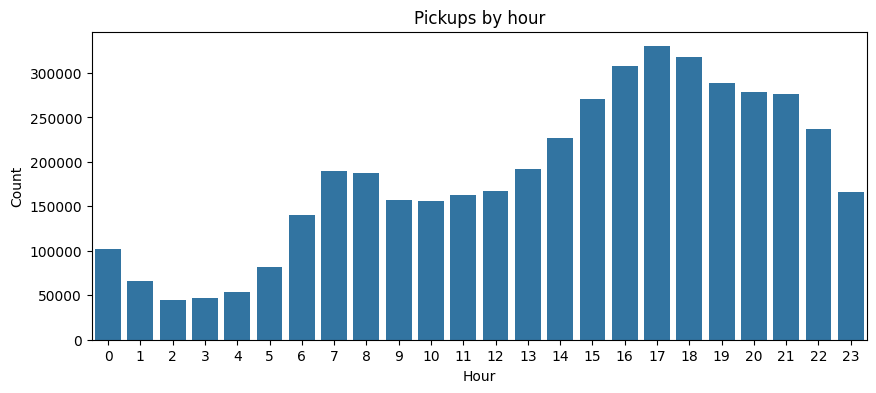

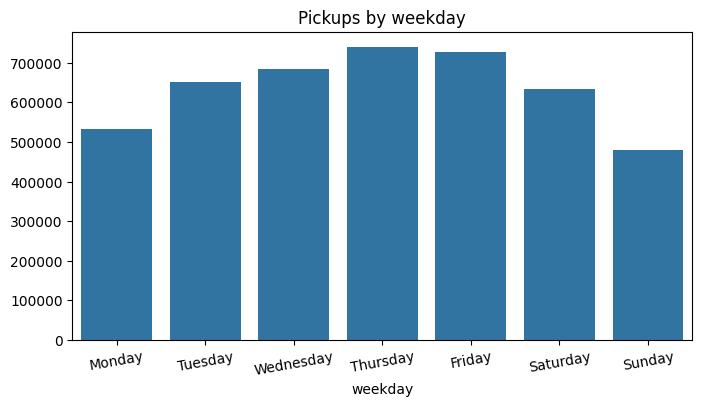

In [9]:
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

# pickups by hour
counts = df.groupby("hour").size().reindex(range(24), fill_value=0)
plt.figure(figsize=(10,4))
sns.barplot(x=counts.index, y=counts.values)
plt.title("Pickups by hour")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()

# pickups by weekday
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
wk = df.groupby("weekday").size().reindex(order, fill_value=0)
plt.figure(figsize=(8,4))
sns.barplot(x=wk.index, y=wk.values)
plt.title("Pickups by weekday")
plt.xticks(rotation=10)
plt.show()
